#### Last Modified: July 26th, 2022 (Opal).

## sOpInf Applied to HUX Solar Wind Radial Speed Dataset for CR2210


In [1]:
import os
curr_dir = os.getcwd()
os.chdir("../")
print("current directory path = ", os.getcwd())

current directory path =  /Users/oissan/PycharmProjects/Space-Weather-ROM-Revised


In [2]:
import numpy as np
import scipy.linalg as la
from scipy.integrate import solve_ivp
from tools.MASweb import get_mas_path
from psipy.model import MASOutput
from psipy.model.variable import Variable
import rom_operator_inference as roi
from scipy import stats
from notebook_functions import *
from hux_code.numerical_methods import apply_numerical_method
from hux_code.hux_propagation import apply_hux_f_model
import time
import astropy.units as u

In [3]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 13}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 

### Import MHD solar wind velocity results.

In [4]:
# mas output - br, rho, vr
cr = "2210"
mas_path = get_mas_path(cr=cr)
model = MASOutput(mas_path)
# read in MHD velocity results. 
vr_model = model['vr']

In [5]:
# save MHD mesh coordinates Heliographic (rotating) Coordinate System (HG)
# phi - (0, 2pi)
p = vr_model.phi_coords
r = (vr_model.r_coords * u.solRad).to(u.km) 
# velocity profile 
f = vr_model.data
print(f.shape)

(128, 111, 140)


In [6]:
omega_rot = (2 * np.pi) / (25.38 * 86400)

In [7]:
#force periodicity on f
#since the last phi index is less than 2*pi, then we will append 2*pi to phi scale.
p = np.append(p, 2*np.pi) 

# append the first slice p=0 to velocity matrix. 
f = np.append(f,[f[0,:, :]],axis=0)

In [8]:
# solve for the velocity field using HUX code. 
V = apply_hux_f_model(f[:, 55, 0], (r[1:]-r[:-1]).to(u.km).value, p[1:] -p[:-1]).T

In [9]:
V.shape

(129, 140)

### Background:  Solar Wind

Due to the high temperature of the Sun's upper atmosphere, called the corona, particles are able to escape the Sun's gravity, resulting in the Solar Wind. The solar wind is a stream of charged particles mostly consists of electrons, protons and alpha particles. The solar wind varies in density, temperature and speed over time and over solar latitude and longitude.

Here we will model the radial velocity of the Solar Wind protons denoted by $v_{r}$. As the solar wind propagates out in the heliosphere it can reach velocities of around 300-700 km/sec. 

In [10]:
def plot_heat_data(Z, title, sample_columns=np.append(np.arange(0, len(r), 20),len(r) -1), variable="v", xlabel="$\phi$ (Deg.)", 
                  save_fig=False, file_name=None):
    fig, ax = plt.subplots(figsize=(14, 4))
    color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))

    for j in sample_columns:
        x_all = np.concatenate([[0], Z[:,j], [0]])  # Pad results with boundary conditions.
        ax.plot(p*(180/np.pi), Z[:,j], color=next(color), label=str(variable) + rf"$(\phi,r$" + "=" + 
                str(round(r[j].to(u.AU).value,2)) + " AU)")

    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_xticks([0, 90, 180, 270, 360])
    ax.set_ylabel(variable + " (km/s)", fontsize=15)
    ax.legend(loc=(1.05, .05))
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=12)
    fig.suptitle(title, fontsize=15)
    
    if save_fig:
        fig.savefig(file_name, dpi=500, bbox_inches='tight')

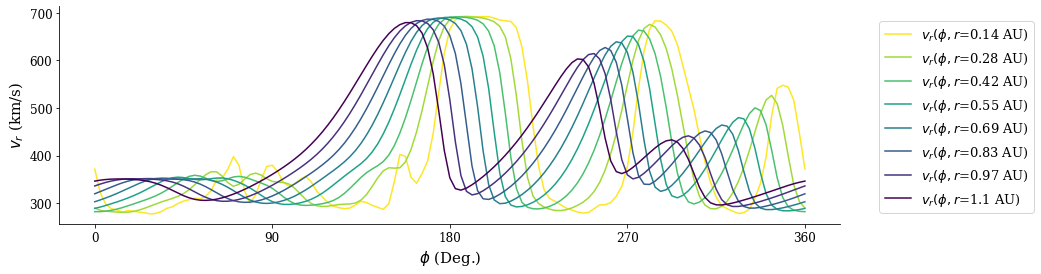

In [11]:
plot_heat_data(V, "", variable=r"$v_{r}$", save_fig=True, file_name="HUX/figs/CR"+ str(cr) +"/original_dataset_HUX.png")

In [12]:
def shift_function(r, r_idx, m=0, b=0, method="moc"):
    if method=="cce":
        return None
    if method=="moc":
        return np.loadtxt('HUX/shock_curve_S1.csv', delimiter=',')[r_idx]

In [13]:
V_new = np.zeros((len(p), len(r)))

V_new[:, 0] = V[:, 0]

for jj in range(1, len(r)):
    # compute shift from the linear fit above. 
    shift = shift_function(r[jj].to(u.AU).value,r_idx=jj, m=0, b=0, method='moc')
    # interpolate over the shifted coordinate
    V_new[:, jj] = np.interp(p + shift*(np.pi/180), p, V[:, jj], period=2*np.pi)

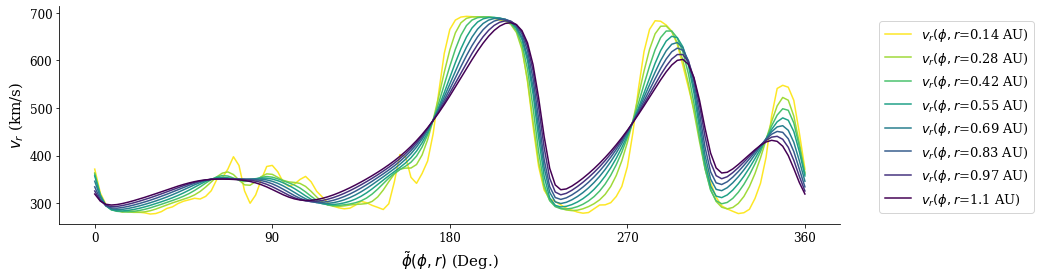

In [14]:
plot_heat_data(V_new, "", variable=r"$v_{r}$", xlabel=r"$\tilde{\phi}(\phi, r)$ (Deg.)", 
              save_fig=True, file_name="HUX/figs/CR"+ str(cr) +"/shifted_dataset_HUX.png")

## Split Training and Testing datasets. 

* Training = First $l$ radial indexes.
* Testing/Validation = Remaining $n_{r}-l$ radial indexes.

In [15]:
# set up the first l indexes used for training. 
l = int(0.7*(len(r)))

In [16]:
X=V_new

In [17]:
X_train = V_new[:, :l]
X_test = V_new[:, l:]

In [18]:
r_train = r[:l]
r_test = r[l:]

In [19]:
print("X train shape", np.shape(X_train))
print("Radial distance train: " + str(r[0].to(u.AU)) + " to " + str(r[l].to(u.AU)))
print("\nX test shape", np.shape(X_test))
print("Radial distance test: " + str(r[l].to(u.AU)) + " to " + str(r[-1].to(u.AU)))

X train shape (129, 98)
Radial distance train: 0.13951401782886472 AU to 0.816444039517221 AU

X test shape (129, 42)
Radial distance test: 0.816444039517221 AU to 1.0996495197497314 AU


## Using the ROM Operator Inference Package

### Linear Model of the form: $\frac{d}{dr}\hat{\mathbf{v}}(r) = \hat{A}\hat{\mathbf{v}}$
First, we seek a reduced model with that same structure,
$$
    \frac{d}{dr}\hat{\mathbf{v}}(r) = \hat{A}\hat{\mathbf{v}}(r),\qquad\hat{\mathbf{v}}(r_{0}) = \hat{\mathbf{v}}_{r_{0}},
$$

but with $\hat{\mathbf{v}}\in \mathbb{R}^{r}$ and $\hat{A}\in\mathbb{R}^{r\times r}$ for some $r\ll n$. Essentially, we apply the **Dynamic Mode Decomposition (DMD)** method to predict the solar wind radial velocity at several heliocentric distances. 

In [20]:
rank = 4 # initialize the rank of ROM
Vr, _ = roi.pre.pod_basis(X_train, r=rank)        # Construct the reduced basis.                       
Xdot_ = roi.pre.xdot_nonuniform(X_train, r_train.value) # Estimate the projected time derivatives.
model = roi.InferredContinuousROM("A")
model.fit(Vr, X_train, Xdot_, P=1e0)
X_ROM = model.predict(X[:, 0], r.value, method="BDF")

### Evaluating the Performance of the ROM

In [21]:
V_ROM_A = convert_from_x_to_v(X_ROM, r=r, p=p, m=0, b=0, method="moc", shift_function=shift_function)

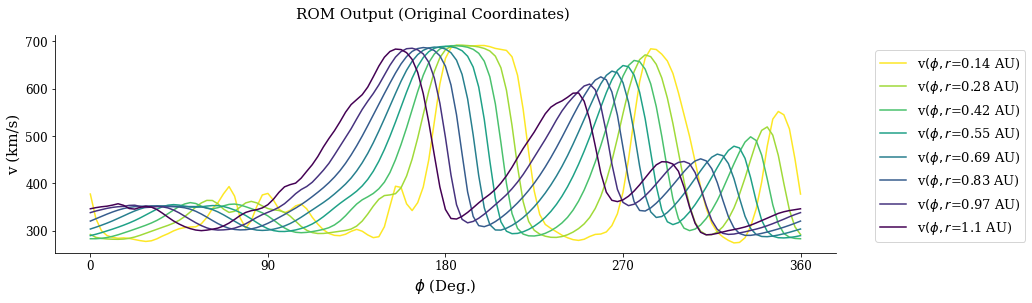

In [22]:
plot_heat_data(V_ROM_A, "ROM Output (Original Coordinates)", variable="v")

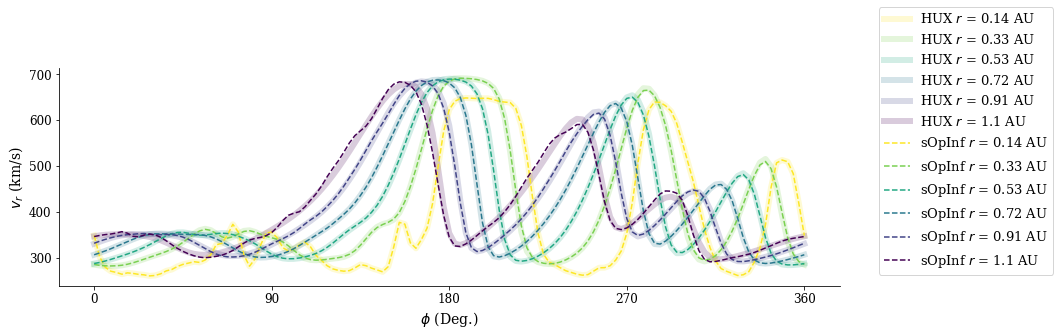

In [23]:
sample_columns = np.arange(0, len(r), int(len(r)//5))
sample_columns = np.append(sample_columns, len(r) -1)
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))

for j in sample_columns:
    curr_color =next(color)
    if j == 0:
        ax.plot(p*(180/np.pi), f[:, 55, j], color=curr_color, linewidth=6.0, alpha=0.2, label=r"HUX $r$ = "+
                str(round(r[j].to(u.AU).value,2)) + " AU")
    else:
        ax.plot(p*(180/np.pi), V[:,j], color=curr_color, linewidth=6.0, alpha=0.2, label=r"HUX $r$ = "+
        str(round(r[j].to(u.AU).value,2)) + " AU")
    
color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))
for j in sample_columns:
    curr_color =next(color)    
    if j == 0:
        ax.plot(p*(180/np.pi), f[:, 55, j], "--", color=curr_color, label=r"sOpInf $r$ = " + 
        str(round(r[j].to(u.AU).value,2)) + " AU")
    else:
        ax.plot(p*(180/np.pi), V_ROM_A[:,j], "--", color=curr_color, label=r"sOpInf $r$ = " + 
            str(round(r[j].to(u.AU).value,2)) + " AU")

ax.set_xlabel("$\phi$ (Deg.)", fontsize=14)
ax.set_xticks([0, 90, 180, 270, 360])
ax.set_ylabel("$v_{r}$ (km/s)", fontsize=14)
ax.legend(loc=(1.05, .05))
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
_ = ax.tick_params(axis='both', which='major', labelsize=12)

fig.savefig("HUX/figs/CR" + str(cr) +"/A/shifted_opinf_results_hux_A.png", dpi=500, bbox_inches='tight')


For more detail, we evaluate the $\ell^2$ error of the ROM output in time, comparing it to the snapshot set.

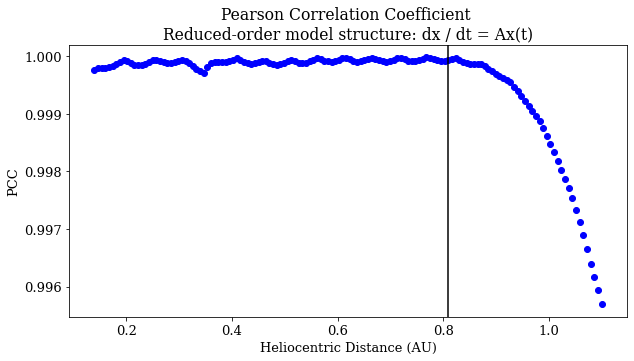

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))
for jj in range(len(r)):
    pcc = stats.pearsonr(V[:, jj], V_ROM_A[:, jj])[0]
    ax.scatter(r.to(u.AU).value[jj], pcc, c="b")
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_xlabel("Heliocentric Distance (AU)")
_ = ax.set_ylabel("PCC")
_ = ax.set_title("Pearson Correlation Coefficient \n" + str(model))

plt.savefig("HUX/figs/CR" + str(cr) + "/A/pcc_shifted_operator_inference_mhd_A.png")

In [25]:
print("2d pcc = ", stats.pearsonr(np.ndarray.flatten(V), np.ndarray.flatten(V_ROM_A))[0])
print("2d pcc training = ", stats.pearsonr(np.ndarray.flatten(V[:, :l]), np.ndarray.flatten(V_ROM_A[:, :l]))[0])
print("2d pcc testing = ", stats.pearsonr(np.ndarray.flatten(V[:, l:]), np.ndarray.flatten(V_ROM_A[:, l:]))[0])
print("Training RE (mean) %", 100*np.mean(np.abs(V[:, :l] - V_ROM_A[:, :l])/np.abs(V[:, :l])))
print("Training RE (max) %", 100*np.max(np.abs(V[:, :l] - V_ROM_A[:, :l])/np.abs(V[:, :l])))
print("Testing RE (mean) %", 100*np.mean(np.abs(V[:, l:] - V_ROM_A[:, l:])/np.abs(V[:, l:])))
print("Testing RE (max) %", 100*np.max(np.abs(V[:, l:] - V_ROM_A[:, l:])/np.abs(V[:, l:])))

2d pcc =  0.9996038639413538
2d pcc training =  0.9998930619123567
2d pcc testing =  0.998742496810749
Training RE (mean) % 0.3127363501610945
Training RE (max) % 4.026947803235275
Testing RE (mean) % 0.7567821016871582
Testing RE (max) % 7.533705826299562


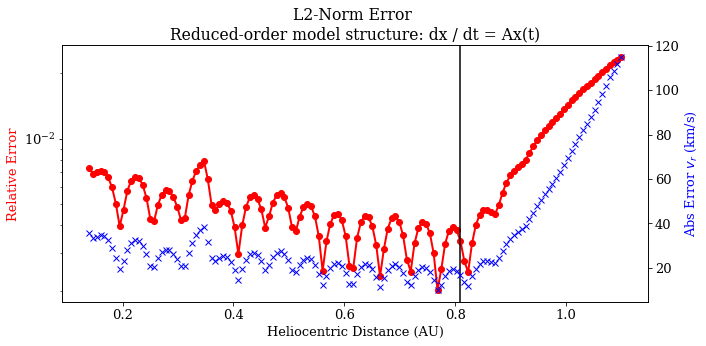

In [26]:
fig, ax = plt.subplots(figsize=(10, 5))
abs_l2errA, rel_l2errA = roi.post.lp_error(V, V_ROM_A)
_ = ax.plot(r.to(u.AU).value, rel_l2errA,"-o", linewidth=2, c="r")
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_title("L2-Norm Error \n" + str(model))
_ = ax.set_ylabel("Relative Error", c="r")
_ = ax.set_yscale("log")
_ = ax.set_xlabel("Heliocentric Distance (AU)")

ax2=ax.twinx()
_ = ax2.plot(r.to(u.AU).value, abs_l2errA, "x", linewidth=2, c="b")
_ = ax2.set_ylabel("Abs Error $v_{r}$ (km/s)", c="b")

plt.tight_layout()
plt.savefig("HUX/figs/CR"+ str(cr) + "/A/L2_error_operator_inference_mhd_A.png", dpi=300)

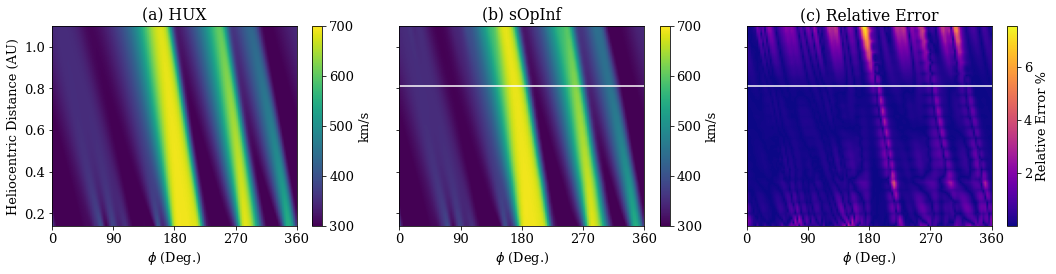

In [27]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(15, 4))
pos = ax[0].imshow(V.T, extent=[0,360,r[0].to(u.AU).value, 
                                r[-1].to(u.AU).value], vmax=700, vmin=300, aspect="auto", origin="lower")
ax[0].set_xlabel(r"$\phi$ (Deg.)")
ax[0].set_ylabel(r"Heliocentric Distance (AU)")
ax[0].set_title("(a) HUX")
ax[0].set_xticks([0, 90, 180, 270, 360])
cbar = fig.colorbar(pos, ax=ax[0])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[1].imshow(V_ROM_A.T, extent=[0,360,r[0].to(u.AU).value, 
                                    r[-1].to(u.AU).value], vmax=700, vmin=300, aspect="auto",  origin="lower")
ax[1].set_xlabel(r"$\phi$ (Deg.)")
ax[1].set_title("(b) sOpInf")
ax[1].set_xticks([0, 90, 180, 270, 360])
ax[1].plot(p*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(len(p)), c="white")
cbar = fig.colorbar(pos, ax=ax[1])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[2].imshow(100*np.abs(V_ROM_A.T - V.T)/np.abs(V.T), 
                   extent=[0,360,r[0].to(u.AU).value, r[-1].to(u.AU).value], 
                   cmap="plasma", aspect="auto", origin="lower")

ax[2].set_xlabel(r"$\phi$ (Deg.)")
ax[2].set_title("(c) Relative Error")
ax[2].set_xticks([0, 90, 180, 270, 360])
ax[2].plot(p*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(len(p)), c="white")
cbar = fig.colorbar(pos, ax=ax[2])
cbar.ax.set_ylabel('Relative Error %', rotation=90)

plt.tight_layout()

In [28]:
print("training mean relative error = ", 100*np.mean(np.abs((V[:, :l]- V_ROM_A[:, :l]))/np.abs(V[:, :l])))
print("training median relative error = ", 100*np.median(np.abs((V[:, :l]- V_ROM_A[:, :l]))/np.abs(V[:, :l])))
print("training max relative error = ", 100*np.max(np.abs((V[:, :l]- V_ROM_A[:, :l]))/np.abs(V[:, :l])))

training mean relative error =  0.3127363501610945
training median relative error =  0.16232460388936534
training max relative error =  4.026947803235275


In [29]:
print("testing mean relative error = ", 100*np.mean(np.abs((V[:, l:]- V_ROM_A[:, l:]))/np.abs(V[:, l:])))
print("testing median relative error = ", 100*np.median(np.abs((V[:, l:]- V_ROM_A[:, l:]))/np.abs(V[:, l:])))
print("testing max relative error = ", 100*np.max(np.abs((V[:, l:]- V_ROM_A[:, l:]))/np.abs(V[:, l:])))

testing mean relative error =  0.7567821016871582
testing median relative error =  0.4341718376136621
testing max relative error =  7.533705826299562


### Can we improve prediction by regularization? to avoid overfitting to the training dataset. Find the optimal regularization coefficient $\lambda_{1}$.

In [30]:
coeff_array = 10**np.arange(0, 10)

training_error = np.ones((len(coeff_array))) * np.inf
testing_error = np.ones((len(coeff_array))) * np.inf

for kk, coeff in enumerate(coeff_array):
    Vr, _ = roi.pre.pod_basis(X_train, r=4) 
    Xdot = roi.pre.xdot_nonuniform(X_train, r_train.value)
    model = roi.InferredContinuousROM(modelform="A")            
    model.fit(Vr, X_train, Xdot, P=coeff)                          
    X_ROM = model.predict(X[:, 0], r.value, method="BDF") 

    if np.shape(X_ROM) == np.shape(V):
        V_ROM = convert_from_x_to_v(X_ROM, r=r, p=p, m=0, b=0, method="moc", shift_function=shift_function)
        # save
        training_error[kk] = np.max(np.abs((V[:, :l] - V_ROM[:, :l])/V[:, :l]))
        # save
        testing_error[kk] = np.max(np.abs((V[:, l:] - V_ROM[:, l:])/V[:, l:]))

In [31]:
coeff_array

array([         1,         10,        100,       1000,      10000,
           100000,    1000000,   10000000,  100000000, 1000000000])

In [32]:
idx  = np.unravel_index(training_error.argmin(), training_error.shape)
print("Training lambda =",  np.log10(coeff_array[idx[0]]))

Training lambda = 0.0


In [33]:
idx  = np.unravel_index(testing_error.argmin(), testing_error.shape)
print("Testing lambda =",  np.log10(coeff_array[idx[0]]))

Testing lambda = 3.0


# Quadratic ROM 
$$\frac{d}{dr}\hat{\mathbf{v}}(r) = \hat{H} (\hat{\mathbf{v}} \otimes \hat{\mathbf{v}})$$

In [34]:
rank = 4 # initialize the rank of ROM
Vr, _ = roi.pre.pod_basis(X_train, r=rank)                    # Construct the reduced basis.
Xdot = roi.pre.xdot_nonuniform(X_train, r_train.value)   # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="H")              # Define the model structure.
model.fit(Vr, X_train, Xdot, P=1E3)                     # Construct the ROM with Operator Inference.
X_ROM = model.predict(X[:, 0], r.value, method="BDF") # Simulate the ROM.

In [35]:
V_ROM_H = convert_from_x_to_v(X_ROM, r=r, p=p, m=0, b=0,method="moc", shift_function=shift_function)

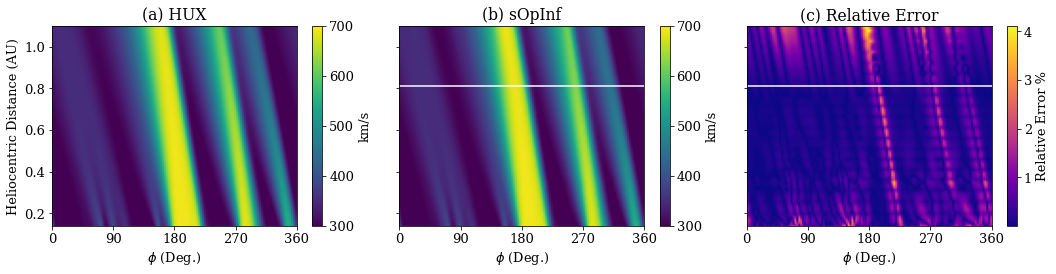

In [37]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(15, 4))
pos = ax[0].imshow(V.T, extent=[0,360,r[0].to(u.AU).value, 
                                r[-1].to(u.AU).value], vmax=700, vmin=300, aspect="auto", origin="lower")
ax[0].set_xlabel(r"$\phi$ (Deg.)")
ax[0].set_ylabel(r"Heliocentric Distance (AU)")
ax[0].set_title("(a) HUX")
ax[0].set_xticks([0, 90, 180, 270, 360])
cbar = fig.colorbar(pos, ax=ax[0])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[1].imshow(V_ROM_H.T, extent=[0,360,r[0].to(u.AU).value, 
                                    r[-1].to(u.AU).value], vmax=700, vmin=300, aspect="auto",  origin="lower")
ax[1].set_xlabel(r"$\phi$ (Deg.)")
ax[1].set_title("(b) sOpInf")
ax[1].set_xticks([0, 90, 180, 270, 360])
ax[1].plot(p*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(len(p)), c="white")
cbar = fig.colorbar(pos, ax=ax[1])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[2].imshow(100*np.abs(V_ROM_H.T - V.T)/np.abs(V.T), 
                   extent=[0,360,r[0].to(u.AU).value, r[-1].to(u.AU).value], 
                   cmap="plasma", aspect="auto", origin="lower")

ax[2].set_xlabel(r"$\phi$ (Deg.)")
ax[2].set_title("(c) Relative Error")
ax[2].set_xticks([0, 90, 180, 270, 360])
ax[2].plot(p*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(len(p)), c="white")
cbar = fig.colorbar(pos, ax=ax[2])
cbar.ax.set_ylabel('Relative Error %', rotation=90)

plt.tight_layout()

In [38]:
print("training mean relative error = ", 100*np.mean(np.abs((V[:, :l]- V_ROM_H[:, :l]))/np.abs(V[:, :l])))
print("training median relative error = ", 100*np.median(np.abs((V[:, :l]- V_ROM_H[:, :l]))/np.abs(V[:, :l])))
print("training max relative error = ", 100*np.max(np.abs((V[:, :l]- V_ROM_H[:, :l]))/np.abs(V[:, :l])))

training mean relative error =  0.28646336143963536
training median relative error =  0.14330647945414632
training max relative error =  3.379058220349033


In [39]:
print("testing mean relative error = ", 100*np.mean(np.abs((V[:, l:]- V_ROM_H[:, l:]))/np.abs(V[:, l:])))
print("testing median relative error = ", 100*np.median(np.abs((V[:, l:]- V_ROM_H[:, l:]))/np.abs(V[:, l:])))
print("testing max relative error = ", 100*np.max(np.abs((V[:, l:]- V_ROM_H[:, l:]))/np.abs(V[:, l:])))

testing mean relative error =  0.5265690521861712
testing median relative error =  0.38538022006513273
testing max relative error =  4.114521824432341


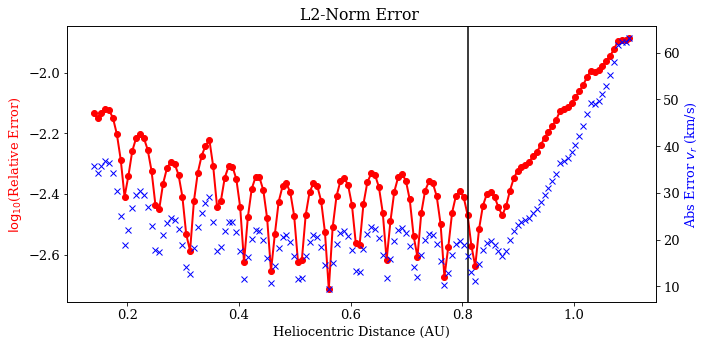

In [40]:
fig, ax = plt.subplots(figsize=(10, 5))
abs_l2errH, rel_l2errH = roi.post.lp_error(V, V_ROM_H)
_ = ax.plot(r.to(u.AU).value, np.log10(rel_l2errH),"-o", linewidth=2, c="r")
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_title(r"L2-Norm Error ")
_ = ax.set_ylabel("$\log_{10}$(Relative Error)", c="r")
_ = ax.set_xlabel("Heliocentric Distance (AU)")

ax2=ax.twinx()
_ = ax2.plot(r.to(u.AU).value, abs_l2errH, "x", linewidth=2, c="b")
_ = ax2.set_ylabel("Abs Error $v_{r}$ (km/s)", c="b")

plt.tight_layout()

plt.savefig("HUX/figs/CR" + str(cr) + "/H/L2_error_operator_inference.png", dpi=300)

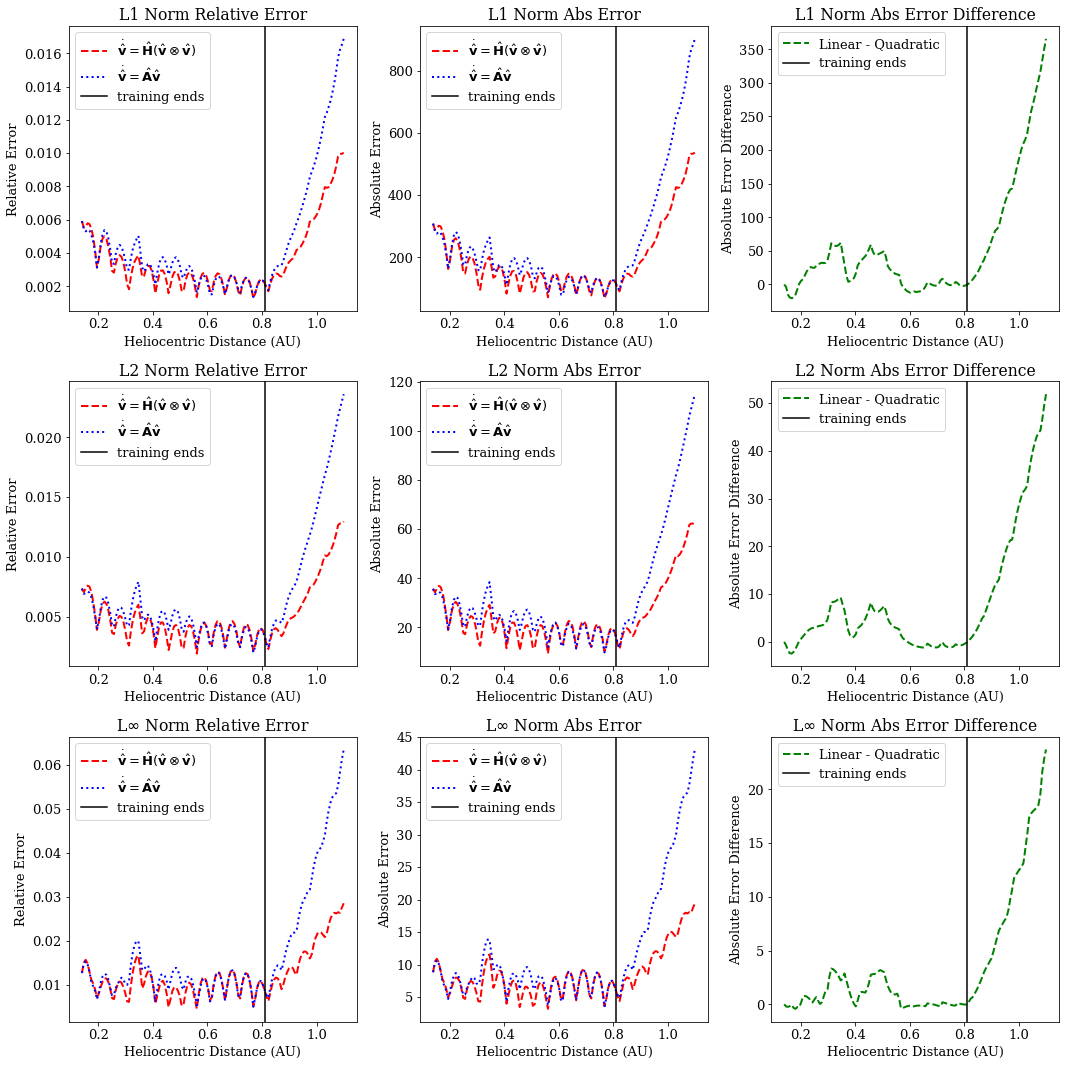

In [41]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(15, 15))

for ii in range(0, 3):
    if ii ==2:
        norm=np.inf
    else:
        norm=ii+1
    abs_l2errA, rel_l2errA = roi.post.lp_error(V, V_ROM_A, p=norm)
    abs_l2errH, rel_l2errH = roi.post.lp_error(V, V_ROM_H, p=norm)

    _ = ax[ii, 0].plot(r.to(u.AU).value, rel_l2errH,"--", linewidth=2, c="r",
                label="$\dot{\hat{\mathbf{v}}} = \hat{\mathbf{H}} (\hat{\mathbf{v}} \otimes \hat{\mathbf{v}})$")
    _ = ax[ii, 0].plot(r.to(u.AU).value, rel_l2errA,":", linewidth=2, c="b", 
                label="$\dot{\hat{\mathbf{v}}} = \hat{\mathbf{A}} \hat{\mathbf{v}} $")

    _ = ax[ii, 0].axvline(r_train[-1].to(u.AU).value, c="k", label="training ends")
    if norm == np.inf:
        _ = ax[ii, 0].set_title(r"L$\infty$ Norm Relative Error")
    else:
        _ = ax[ii, 0].set_title(r"L" + str(ii+1)+ " Norm Relative Error")
        
    _ = ax[ii, 0].set_ylabel("Relative Error", c="k")
    _ = ax[ii, 0].set_xlabel("Heliocentric Distance (AU)")
    _ = ax[ii, 0].legend()

    _ = ax[ii, 1].plot(r.to(u.AU).value, abs_l2errH,"--", linewidth=2, c="r",
                label="$\dot{\hat{\mathbf{v}}} = \hat{\mathbf{H}} (\hat{\mathbf{v}} \otimes \hat{\mathbf{v}})$")
    _ = ax[ii, 1].plot(r.to(u.AU).value, abs_l2errA,":", linewidth=2, c="b", 
                label="$\dot{\hat{\mathbf{v}}} = \hat{\mathbf{A}} \hat{\mathbf{v}} $")
    _ = ax[ii, 1].axvline(r_train[-1].to(u.AU).value, c="k", label="training ends")
    if norm == np.inf:
        _ = ax[ii, 1].set_title(r"L$\infty$ Norm Abs Error")
    else:
        _ = ax[ii, 1].set_title(r"L" + str(ii+1)+ " Norm Abs Error")
    _ = ax[ii, 1].set_ylabel("Absolute Error", c="k")
    _ = ax[ii, 1].set_xlabel("Heliocentric Distance (AU)")
    _ = ax[ii, 1].legend()


    _ = ax[ii, 2].plot(r.to(u.AU).value, abs_l2errA - abs_l2errH,"--", linewidth=2, c="green", label="Linear - Quadratic")

    _ = ax[ii, 2].axvline(r_train[-1].to(u.AU).value, c="k", label="training ends")
    if norm == np.inf:
        _ = ax[ii, 2].set_title(r"L$\infty$ Norm Abs Error Difference")
    else:
        _ = ax[ii, 2].set_title(r"L" + str(ii+1)+ " Norm Abs Error Difference")
    _ = ax[ii, 2].set_ylabel("Absolute Error Difference", c="k")
    _ = ax[ii, 2].set_xlabel("Heliocentric Distance (AU)")
    _ = ax[ii, 2].legend()

plt.tight_layout()

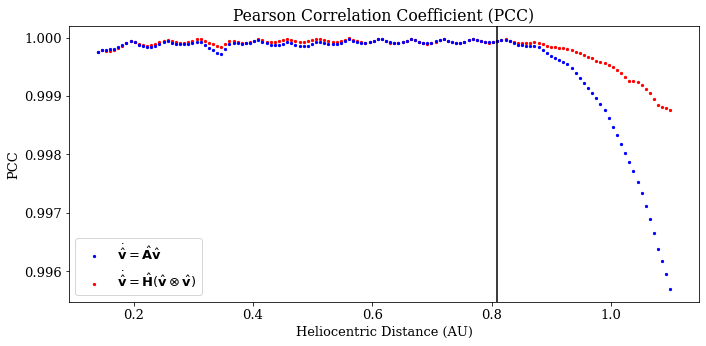

In [42]:
fig, ax = plt.subplots(figsize=(10, 5))
for jj in range(len(r)):
    pcc = stats.pearsonr(V[:, jj], V_ROM_H[:, jj])[0]
    ax.scatter(r.to(u.AU).value[jj], pcc, c="r", s=5)
    pcc = stats.pearsonr(V[:, jj], V_ROM_A[:, jj])[0]
    ax.scatter(r.to(u.AU).value[jj], pcc, c="b", s=5)
_ = ax.scatter(np.nan, np.nan, s=5, c="b", label="$\dot{\hat{\mathbf{v}}} = \hat{\mathbf{A}} \hat{\mathbf{v}} $")
_ = ax.scatter(np.nan, np.nan, s=5, c="r", label="$\dot{\hat{\mathbf{v}}} = \hat{\mathbf{H}} (\hat{\mathbf{v}} \otimes \hat{\mathbf{v}})$")
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_xlabel("Heliocentric Distance (AU)")
_ = ax.set_ylabel("PCC")
_ = ax.set_title("Pearson Correlation Coefficient (PCC)")
_ = ax.legend()
plt.tight_layout()
plt.savefig("HUX/figs/CR" + str(cr) + "/H/pcc_shifted_operator_inference_comparison.png", dpi=300)

In [43]:
print("2d pcc = ", stats.pearsonr(np.ndarray.flatten(V), np.ndarray.flatten(V_ROM_H))[0])
print("2d pcc training = ", stats.pearsonr(np.ndarray.flatten(V[:, :l]), np.ndarray.flatten(V_ROM_H[:, :l]))[0])
print("2d pcc testing = ", stats.pearsonr(np.ndarray.flatten(V[:, l:]), np.ndarray.flatten(V_ROM_H[:, l:]))[0])

2d pcc =  0.999820826162968
2d pcc training =  0.9999159215104843
2d pcc testing =  0.9995621364803526


### Can we improve prediction by regularization? to avoid overfitting to the training dataset. Find the optimal regularization coefficient $\lambda_{1}$ and rank $r$.

In [44]:
coeff_array = 10**np.arange(0, 10)

training_error = np.ones((len(coeff_array))) * np.inf
testing_error = np.ones((len(coeff_array))) * np.inf

for kk, coeff in enumerate(coeff_array):
    Vr, _ = roi.pre.pod_basis(X_train, r=4) 
    Xdot = roi.pre.xdot_nonuniform(X_train, r_train.value) 
    model = roi.InferredContinuousROM(modelform="H")            
    model.fit(Vr, X_train, Xdot, P=coeff)                          
    X_ROM = model.predict(X[:, 0], r.value, method="BDF") 

    if np.shape(X_ROM) == np.shape(V):
        V_ROM = convert_from_x_to_v(X_ROM, r=r, p=p, m=0, b=0, method="moc", shift_function=shift_function)
        # save
        training_error[kk] = np.max(np.abs((V[:, :l] - V_ROM[:, :l])/V[:, :l]))
        # save
        testing_error[kk] = np.max(np.abs((V[:, l:] - V_ROM[:, l:])/V[:, l:]))

In [45]:
idx  = np.unravel_index(training_error.argmin(), training_error.shape)
print("Training lambda =",  np.log10(coeff_array[idx[0]]))

Training lambda = 3.0


In [46]:
idx  = np.unravel_index(testing_error.argmin(), testing_error.shape)
print("Testing lambda =",  np.log10(coeff_array[idx[0]]))

Testing lambda = 3.0


### Quadratic + Linear ROM 
$$\frac{d}{dr}\hat{\mathbf{v}}(r) = \hat{c} + \hat{A}\hat{\mathbf{v}} +\hat{H} (\hat{\mathbf{v}} \otimes \hat{\mathbf{v}})$$

In [47]:
rank=4
Vr, _ = roi.pre.pod_basis(X_train, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot_nonuniform(X_train, r_train.value)            # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="cAH")              # Define the model structure.
model.fit(Vr, X_train, Xdot, P=regularizer(rank, 10**(8), 10**(3)))                         # Construct the ROM with Operator Inference.
X_ROM = model.predict(X[:, 0], r.value, method="BDF") # Simulate the ROM.
V_ROM_cAH = convert_from_x_to_v(X_ROM,r=r, p=p, m=0, b=0, method="moc", shift_function=shift_function)

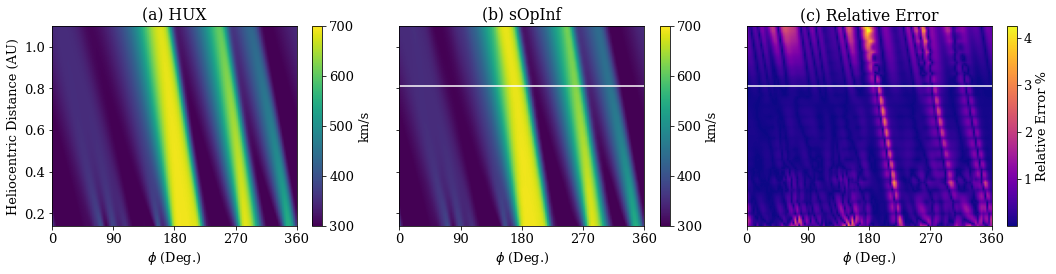

In [48]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(15, 4))
pos = ax[0].imshow(V.T, extent=[0,360,r[0].to(u.AU).value, 
                                r[-1].to(u.AU).value], vmax=700, vmin=300, aspect="auto", origin="lower")
ax[0].set_xlabel(r"$\phi$ (Deg.)")
ax[0].set_ylabel(r"Heliocentric Distance (AU)")
ax[0].set_title("(a) HUX")
ax[0].set_xticks([0, 90, 180, 270, 360])
cbar = fig.colorbar(pos, ax=ax[0])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[1].imshow(V_ROM_cAH.T, extent=[0,360,r[0].to(u.AU).value, 
                                    r[-1].to(u.AU).value], vmax=700, vmin=300, aspect="auto",  origin="lower")
ax[1].set_xlabel(r"$\phi$ (Deg.)")
ax[1].set_title("(b) sOpInf")
ax[1].set_xticks([0, 90, 180, 270, 360])
ax[1].plot(p*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(len(p)), c="white")
cbar = fig.colorbar(pos, ax=ax[1])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[2].imshow(100*np.abs(V_ROM_cAH.T - V.T)/np.abs(V.T), 
                   extent=[0,360,r[0].to(u.AU).value, r[-1].to(u.AU).value], 
                   cmap="plasma", aspect="auto", origin="lower")

ax[2].set_xlabel(r"$\phi$ (Deg.)")
ax[2].set_title("(c) Relative Error")
ax[2].set_xticks([0, 90, 180, 270, 360])
ax[2].plot(p*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(len(p)), c="white")
cbar = fig.colorbar(pos, ax=ax[2])
cbar.ax.set_ylabel('Relative Error %', rotation=90)

plt.tight_layout()

In [49]:
print("training mean relative error = ", 100*np.mean(np.abs((V[:, :l]- V_ROM_cAH[:, :l]))/np.abs(V[:, :l])))
print("training median relative error = ", 100*np.median(np.abs((V[:, :l]- V_ROM_cAH[:, :l]))/np.abs(V[:, :l])))
print("training max relative error = ", 100*np.max(np.abs((V[:, :l]- V_ROM_cAH[:, :l]))/np.abs(V[:, :l])))

training mean relative error =  0.29774359245357374
training median relative error =  0.15900894160706383
training max relative error =  3.198796852943152


In [50]:
print("testing mean relative error = ", 100*np.mean(np.abs((V[:, l:]- V_ROM_cAH[:, l:]))/np.abs(V[:, l:])))
print("testing median relative error = ", 100*np.median(np.abs((V[:, l:]- V_ROM_cAH[:, l:]))/np.abs(V[:, l:])))
print("testing max relative error = ", 100*np.max(np.abs((V[:, l:]- V_ROM_cAH[:, l:]))/np.abs(V[:, l:])))

testing mean relative error =  0.5405614401260672
testing median relative error =  0.39624062888421374
testing max relative error =  4.260028954155614


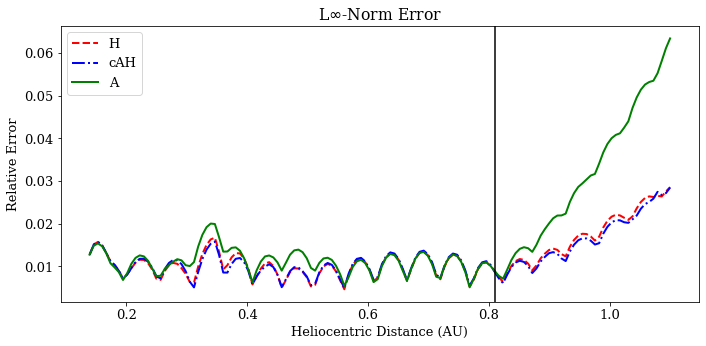

In [51]:
fig, ax = plt.subplots(figsize=(10, 5))

abs_l2errcAH, rel_l2errcAH = roi.post.lp_error(V, V_ROM_cAH, p=np.inf)
abs_l2errA, rel_l2errA = roi.post.lp_error(V, V_ROM_A, p=np.inf)
abs_l2errH, rel_l2errH = roi.post.lp_error(V, V_ROM_H, p=np.inf)

_ = ax.plot(r.to(u.AU).value, rel_l2errH,"--", linewidth=2, c="r", label="H")
_ = ax.plot(r.to(u.AU).value, rel_l2errcAH,"-.", linewidth=2, c="b", label="cAH")
_ = ax.plot(r.to(u.AU).value, rel_l2errA,"-", linewidth=2, c="g", label="A")

_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_title("L$\infty$-Norm Error")
_ = ax.set_ylabel("Relative Error", c="k")
_ = ax.set_xlabel("Heliocentric Distance (AU)")

#plt.yscale("log")
plt.tight_layout()
plt.legend()

In [52]:
coeff1_array = 10**np.arange(0, 15)
coeff2_array = 10**np.arange(0, 15)
training_error = np.ones((len(coeff1_array),  len(coeff2_array))) * np.inf
testing_error = np.ones((len(coeff1_array),  len(coeff2_array))) * np.inf

for kk, coeff1 in enumerate(coeff1_array):
    for jj, coeff2 in enumerate(coeff2_array):
        Vr, _ = roi.pre.pod_basis(X_train, r=4) 
        Xdot = roi.pre.xdot_nonuniform(X_train, r_train.value)
        model = roi.InferredContinuousROM(modelform="cAH")            
        model.fit(Vr, X_train, Xdot, P=regularizer(4, coeff1, coeff2))                          
        X_ROM = model.predict(X[:,  0], r.value, method="BDF") 

        if np.shape(X_ROM) == np.shape(V):
            V_ROM = convert_from_x_to_v(X_ROM, r=r, p=p, m=0, b=0,method="moc", shift_function=shift_function)
            # save
            training_error[kk, jj] = np.max(np.abs((V[:, :l] - V_ROM[:, :l])/V[:, :l]))
            # save
            testing_error[kk, jj] = np.max(np.abs((V[:, l:] - V_ROM[:, l:])/V[:, l:]))

normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve faile

Text(0, 0.5, '$\\log_{10}(\\lambda_{2})$')

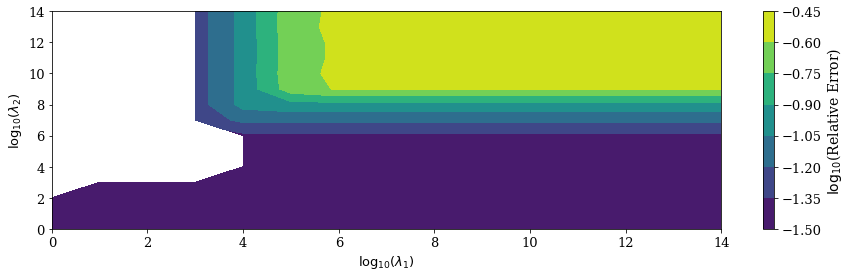

In [53]:
fig, ax = plt.subplots(figsize=(15, 4))
lam1_grid, lam2_grid = np.meshgrid(np.log10(coeff1_array), np.log10(coeff2_array))
pos = ax.contourf(lam1_grid, lam2_grid, np.log10(training_error).T, cmap="viridis")
cbar = fig.colorbar(pos, ax=ax)
cbar.ax.set_ylabel(r'$\log_{10}$(Relative Error)', rotation=90, fontsize=14)
ax.set_xlabel("$\log_{10}(\lambda_{1})$")
ax.set_ylabel("$\log_{10}(\lambda_{2})$")

In [54]:
idx  = np.unravel_index(training_error.argmin(), training_error.shape)
print("Training lambda1 =",  np.log10(coeff1_array[idx[0]]))
print("Training lambda2 =",  np.log10(coeff2_array[idx[1]]))

Training lambda1 = 8.0
Training lambda2 = 3.0


In [55]:
idx  = np.unravel_index(testing_error.argmin(), testing_error.shape)
print("Testing lambda1 =",  np.log10(coeff1_array[idx[0]]))
print("Testing lambda2 =",  np.log10(coeff2_array[idx[1]]))

Testing lambda1 = 1.0
Testing lambda2 = 3.0


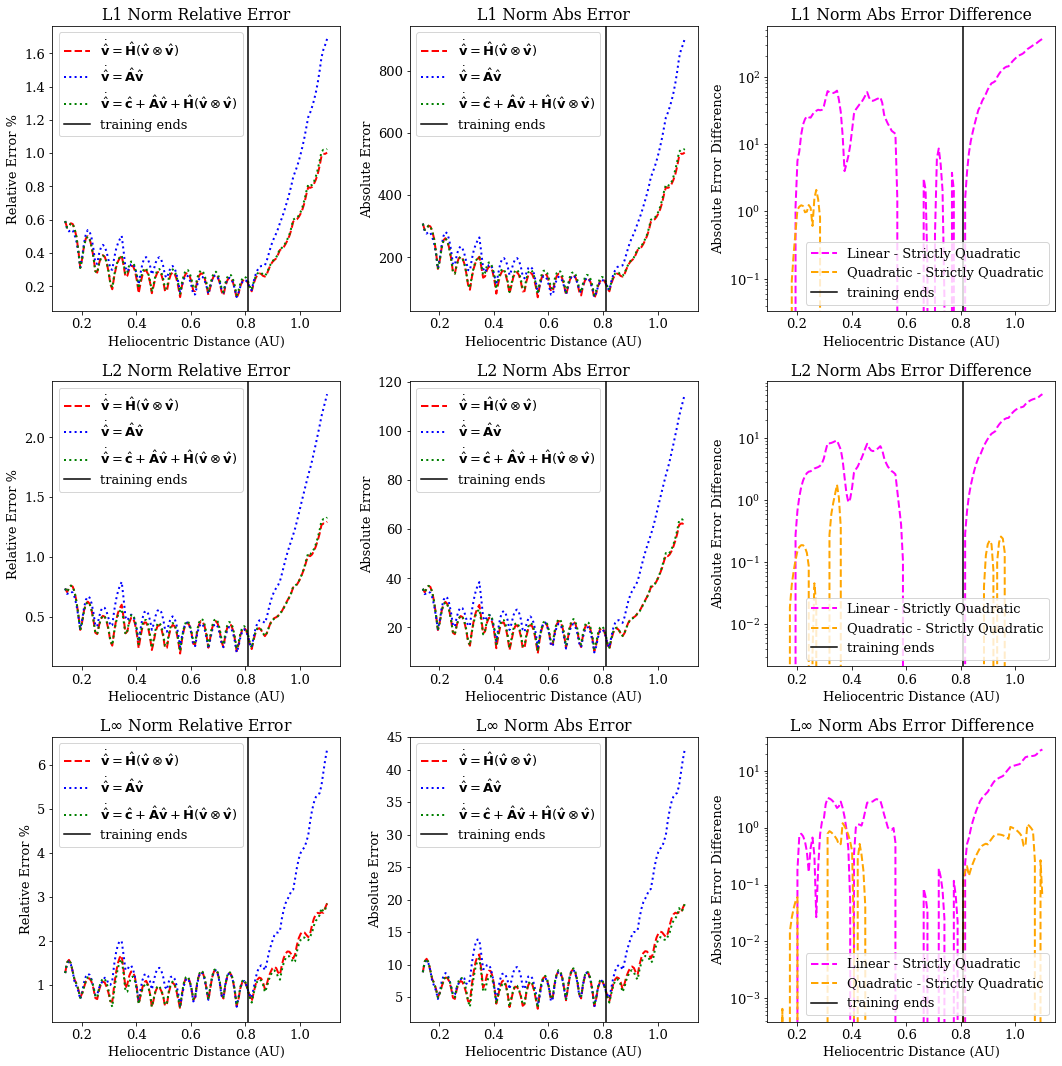

In [56]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(15, 15))

for ii in range(0, 3):
    if ii ==2:
        norm=np.inf
    else:
        norm=ii+1
    abs_l2errA, rel_l2errA = roi.post.lp_error(V, V_ROM_A, p=norm)
    abs_l2errH, rel_l2errH = roi.post.lp_error(V, V_ROM_H, p=norm)
    abs_l2errcAH, rel_l2errcAH = roi.post.lp_error(V, V_ROM_cAH, p=norm)

    _ = ax[ii, 0].plot(r.to(u.AU).value, 100*rel_l2errH,"--", linewidth=2, c="r",
                label="$\dot{\hat{\mathbf{v}}} = \hat{\mathbf{H}} (\hat{\mathbf{v}} \otimes \hat{\mathbf{v}})$")
    _ = ax[ii, 0].plot(r.to(u.AU).value, 100*rel_l2errA,":", linewidth=2, c="b", 
                label="$\dot{\hat{\mathbf{v}}} = \hat{\mathbf{A}} \hat{\mathbf{v}} $")
    _ = ax[ii, 0].plot(r.to(u.AU).value, 100*rel_l2errcAH,":", linewidth=2, c="g", 
                label="$\dot{\hat{\mathbf{v}}} = \hat{\mathbf{c}} + \hat{\mathbf{A}} \hat{\mathbf{v}}+ \hat{\mathbf{H}} (\hat{\mathbf{v}} \otimes \hat{\mathbf{v}})$")
    _ = ax[ii, 0].axvline(r_train[-1].to(u.AU).value, c="k", label="training ends")
    if norm == np.inf:
        _ = ax[ii, 0].set_title(r"L$\infty$ Norm Relative Error")
    else:
        _ = ax[ii, 0].set_title(r"L" + str(ii+1)+ " Norm Relative Error")
        
    _ = ax[ii, 0].set_ylabel("Relative Error %", c="k")
    _ = ax[ii, 0].set_xlabel("Heliocentric Distance (AU)")
    _ = ax[ii, 0].legend()

    _ = ax[ii, 1].plot(r.to(u.AU).value, abs_l2errH,"--", linewidth=2, c="r",
                label="$\dot{\hat{\mathbf{v}}} = \hat{\mathbf{H}} (\hat{\mathbf{v}} \otimes \hat{\mathbf{v}})$")
    _ = ax[ii, 1].plot(r.to(u.AU).value, abs_l2errA,":", linewidth=2, c="b", 
                label="$\dot{\hat{\mathbf{v}}} = \hat{\mathbf{A}} \hat{\mathbf{v}} $")
    _ = ax[ii, 1].plot(r.to(u.AU).value, abs_l2errcAH,":", linewidth=2, c="g", 
                label="$\dot{\hat{\mathbf{v}}} = \hat{\mathbf{c}} + \hat{\mathbf{A}} \hat{\mathbf{v}}+ \hat{\mathbf{H}} (\hat{\mathbf{v}} \otimes \hat{\mathbf{v}})$")
    _ = ax[ii, 1].axvline(r_train[-1].to(u.AU).value, c="k", label="training ends")
    if norm == np.inf:
        _ = ax[ii, 1].set_title(r"L$\infty$ Norm Abs Error")
    else:
        _ = ax[ii, 1].set_title(r"L" + str(ii+1)+ " Norm Abs Error")
    _ = ax[ii, 1].set_ylabel("Absolute Error", c="k")
    _ = ax[ii, 1].set_xlabel("Heliocentric Distance (AU)")
    _ = ax[ii, 1].legend()


    _ = ax[ii, 2].plot(r.to(u.AU).value, abs_l2errA - abs_l2errH,"--", linewidth=2, c="magenta", label="Linear - Strictly Quadratic")
    _ = ax[ii, 2].plot(r.to(u.AU).value, abs_l2errH - abs_l2errcAH,"--", linewidth=2, c="orange", label="Quadratic - Strictly Quadratic")

    _ = ax[ii, 2].axvline(r_train[-1].to(u.AU).value, c="k", label="training ends")
    _ = ax[ii, 2].set_yscale("log")
    if norm == np.inf:
        _ = ax[ii, 2].set_title(r"L$\infty$ Norm Abs Error Difference")
    else:
        _ = ax[ii, 2].set_title(r"L" + str(ii+1)+ " Norm Abs Error Difference")
    _ = ax[ii, 2].set_ylabel("Absolute Error Difference", c="k")
    _ = ax[ii, 2].set_xlabel("Heliocentric Distance (AU)")
    _ = ax[ii, 2].legend()

plt.tight_layout()

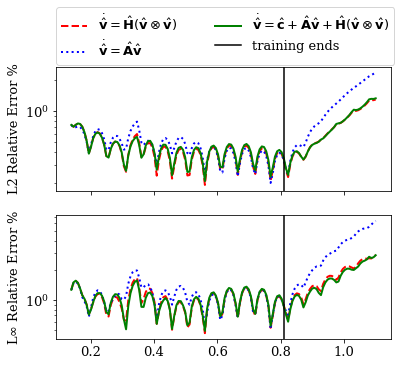

In [57]:
fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(6,5))

for ii in range(1, 3):
    if ii ==2:
        norm=np.inf
    else:
        norm=ii+1
    abs_l2errA, rel_l2errA = roi.post.lp_error(V, V_ROM_A, p=norm)
    abs_l2errH, rel_l2errH = roi.post.lp_error(V, V_ROM_H, p=norm)
    abs_l2errcAH, rel_l2errcAH = roi.post.lp_error(V, V_ROM_cAH, p=norm)
    
 
    _ = ax[ii-1].plot(r.to(u.AU).value, 100*rel_l2errH,"--", linewidth=2, c="r",
                label="$\dot{\hat{\mathbf{v}}} = \hat{\mathbf{H}} (\hat{\mathbf{v}} \otimes \hat{\mathbf{v}})$")
    _ = ax[ii-1].plot(r.to(u.AU).value, 100*rel_l2errA,":", linewidth=2, c="b", 
                label="$\dot{\hat{\mathbf{v}}} = \hat{\mathbf{A}} \hat{\mathbf{v}} $")
    _ = ax[ii-1].plot(r.to(u.AU).value, 100*rel_l2errcAH,"-", linewidth=2, c="g", 
                label="$\dot{\hat{\mathbf{v}}} = \hat{\mathbf{c}} + \hat{\mathbf{A}} \hat{\mathbf{v}}+ \hat{\mathbf{H}} (\hat{\mathbf{v}} \otimes \hat{\mathbf{v}})$")
    _ = ax[ii-1].axvline(r_train[-1].to(u.AU).value, c="k", label="training ends")

    if norm == np.inf:
        _ = ax[ii-1].set_ylabel("L$\infty$ Relative Error %", c="k")
    else:
        _ = ax[ii-1].set_ylabel(r"L" + str(ii+1)+" Relative Error %", c="k")
    _ = ax[ii-1].set_yscale("log")
ax[0].legend(bbox_to_anchor=(0., 1.02, 1.01, 0.102), loc=3, ncol=2, mode="expand", borderaxespad=0)

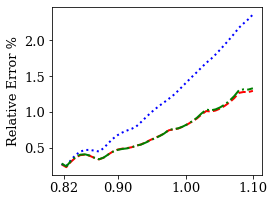

In [58]:
fig, ax = plt.subplots(ncols=1, nrows=1, sharex=True, figsize=(4,3))

norm=2
abs_l2errA, rel_l2errA = roi.post.lp_error(V, V_ROM_A, p=norm)
abs_l2errH, rel_l2errH = roi.post.lp_error(V, V_ROM_H, p=norm)
abs_l2errcAH, rel_l2errcAH = roi.post.lp_error(V, V_ROM_cAH, p=norm)


_ = ax.plot(r[l:].to(u.AU).value, 100*rel_l2errH[l:],"--", linewidth=2, c="r",
            label="$\dot{\hat{\mathbf{v}}} = \hat{\mathbf{H}} (\hat{\mathbf{v}} \otimes \hat{\mathbf{v}})$")
_ = ax.plot(r[l:].to(u.AU).value, 100*rel_l2errA[l:],":", linewidth=2, c="b", 
            label="$\dot{\hat{\mathbf{v}}} = \hat{\mathbf{A}} \hat{\mathbf{v}} $")
_ = ax.plot(r[l:].to(u.AU).value, 100*rel_l2errcAH[l:],"-.", linewidth=2, c="g", 
            label="$\dot{\hat{\mathbf{v}}} = \hat{\mathbf{c}} + \hat{\mathbf{A}} \hat{\mathbf{v}}+ \hat{\mathbf{H}} (\hat{\mathbf{v}} \otimes \hat{\mathbf{v}})$")

_ = ax.set_xticks([0.82, 0.9, 1, 1.1])
_ = ax.set_ylabel(r"Relative Error %", c="k")
plt.tight_layout()
plt.savefig("HUX/figs/HUX_Equator_comparison_model_form.png", dpi=600)